## Семинар 2: Работа с данными и создание нейронных сетей


In [2]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Поиск ошибок в архитектурах нейронных сетей


In [18]:
# Модель 1
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout2d(0.5)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc = nn.Linear(128 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop1(self.bn1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# model1 = CNN1()
# test_input = torch.randn(1, 3, 64, 64)
# output = model1(test_input)

In [19]:
# Модель 2
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


model2 = CNN2()
test_input = torch.randn(1, 3, 64, 64)
output = model2(test_input)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x32 and 64x128)

In [20]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch1 = nn.Conv2d(3, 64, 3, padding=1)
        self.branch2 = nn.Conv2d(3, 128, 5, padding=2)
        self.fc = nn.Linear(192 * 16 * 16, 10)

    def forward(self, x):
        b1 = F.relu(self.branch1(x))
        b2 = F.relu(self.branch2(x))
        out = torch.cat([b1, b2], dim=1) # dim 0 раньше был
        out = out.view(out.size(0), -1)
        return self.fc(out)

model3 = CNN3()
test_input = torch.randn(1, 3, 64, 64)
output = model3(test_input)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x786432 and 49152x10)

## Создание собственного DataLoader


### Что такое Dataset?
- **Dataset** - это класс, который индексирует и возвращает один образец данных
- **DataLoader** - это итератор, который группирует данные в батчи и предоставляет многопроцессную загрузку

### Основные методы Dataset:
- `__init__()` - инициализация, загрузка метаданных
- `__len__()` - возвращает размер датасета
- `__getitem__(idx)` - возвращает элемент по индексу

** Создадим собственный DataLoader для Tiny ImageNet:**


In [21]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "data/tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")

Train size: 100000
Val size: 10000
Классов: 200


## Визуализация данных


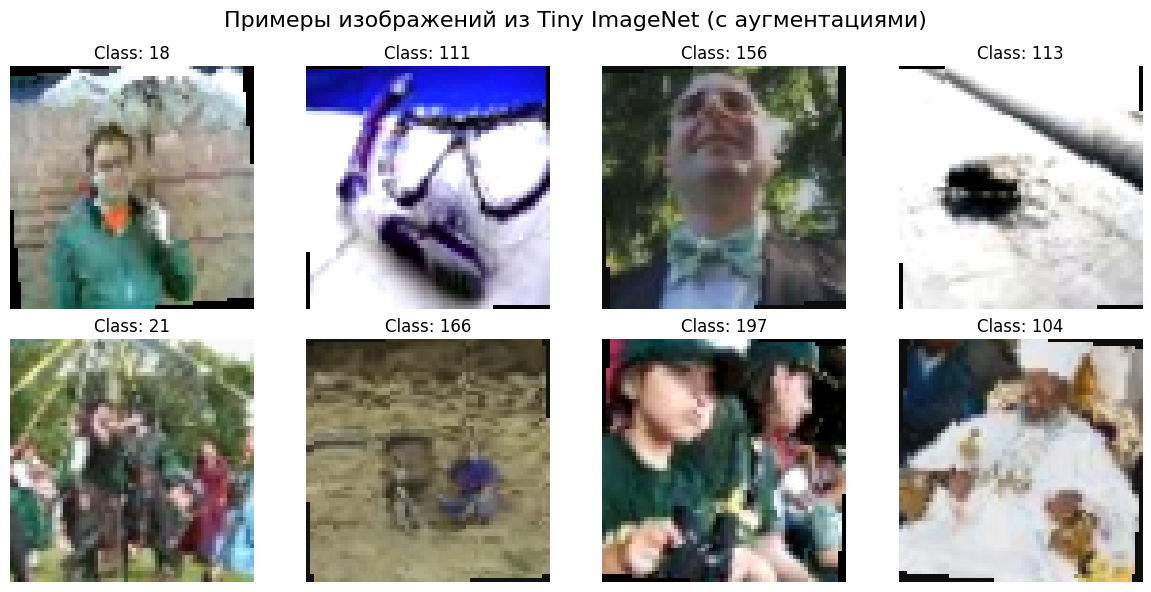

Размер батча: torch.Size([8, 3, 64, 64])
Диапазон значений: [-2.118, 2.640]
Метки классов: [18, 111, 156, 113, 21, 166, 197, 104]
Всего классов в датасете: 200
Примеры названий классов: ['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582']


In [22]:
images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu()

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset.class_names)}")
print(f"Примеры названий классов: {train_dataset.class_names[:5]}")

---


### Стратификация данных

### Что такое стратификация?
**Стратификация** - это метод разделения данных, при котором сохраняется пропорциональное представление классов в каждой части.

###  Зачем нужна стратификация?
- Обеспечивает равномерное распределение классов между train/val/test
- Предотвращает переобучение на доминирующих классах
- Дает более надежную оценку качества модели

###  Типы стратификации:
1. **Случайная стратификация** - простое случайное разделение
2. **K-Fold стратификация** - разделение на k частей
3. **Стратификация по эмбедингам** - разделение на основе семантических признаков

** Рассмотрим различные подходы:**


#### Метод 1: Простая случайная стратификация


In [3]:
print(" Метод 1: Простая случайная стратификация")

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
all_samples = train_dataset.samples

print(f" Всего образцов: {len(all_samples)}")

random.seed(42)
all_samples_copy = all_samples.copy()
random.shuffle(all_samples_copy)

val_fraction = 0.2
split_idx = int(len(all_samples_copy) * (1 - val_fraction))
train_split_random = all_samples_copy[:split_idx]
val_split_random = all_samples_copy[split_idx:]

print(f" Случайное разделение:")
print(f"   Train: {len(train_split_random)} образцов")
print(f"   Val: {len(val_split_random)} образцов")

def analyze_class_distribution(samples, name):
    labels = [label for _, label in samples]
    class_counts = Counter(labels)
    print(f" {name} - распределение классов:")
    print(f"   Минимум: {min(class_counts.values())}")
    print(f"   Максимум: {max(class_counts.values())}")
    print(f"   Среднее: {np.mean(list(class_counts.values())):.1f}")
    print(f"   Стандартное отклонение: {np.std(list(class_counts.values())):.1f}")

analyze_class_distribution(train_split_random, "Случайное train")
analyze_class_distribution(val_split_random, "Случайное val")


 Метод 1: Простая случайная стратификация
 Всего образцов: 100000
 Случайное разделение:
   Train: 80000 образцов
   Val: 20000 образцов
 Случайное train - распределение классов:
   Минимум: 377
   Максимум: 424
   Среднее: 400.0
   Стандартное отклонение: 9.3
 Случайное val - распределение классов:
   Минимум: 76
   Максимум: 123
   Среднее: 100.0
   Стандартное отклонение: 9.3


#### Метод 2: Cтратификация с помощью sklearn


In [4]:


X = [x for x, y in all_samples]  # пути к изображениям
y = [y for x, y in all_samples]  # метки классов

print(f" Подготовлено {len(X)} образцов с {len(set(y))} классами")

sss = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

# Создаем стратифицированные разделения
train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print(f" Стратифицированное разделение:")
print(f"   Train: {len(train_split_stratified)} образцов")
print(f"   Val: {len(val_split_stratified)} образцов")

# Анализируем распределение классов
analyze_class_distribution(train_split_stratified, "Стратифицированное train")
analyze_class_distribution(val_split_stratified, "Стратифицированное val")


 Подготовлено 100000 образцов с 200 классами
 Стратифицированное разделение:
   Train: 80000 образцов
   Val: 20000 образцов
 Стратифицированное train - распределение классов:
   Минимум: 400
   Максимум: 400
   Среднее: 400.0
   Стандартное отклонение: 0.0
 Стратифицированное val - распределение классов:
   Минимум: 100
   Максимум: 100
   Среднее: 100.0
   Стандартное отклонение: 0.0


#### Метод 3: K-Fold стратификация


In [5]:
# K-Fold стратификация

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

print(f" Разделение на {k} фолдов:")
fold_splits = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_split = [all_samples[i] for i in train_idx]
    val_split = [all_samples[i] for i in val_idx]
    fold_splits.append((train_split, val_split))
    print(f"   Fold {fold}: train={len(train_split)}, val={len(val_split)}")

print(f" Анализ первого фолда:")
analyze_class_distribution(fold_splits[0][0], "Fold 0 train")
analyze_class_distribution(fold_splits[0][1], "Fold 0 val")


 Разделение на 5 фолдов:
   Fold 0: train=80000, val=20000
   Fold 1: train=80000, val=20000
   Fold 2: train=80000, val=20000
   Fold 3: train=80000, val=20000
   Fold 4: train=80000, val=20000
 Анализ первого фолда:
 Fold 0 train - распределение классов:
   Минимум: 400
   Максимум: 400
   Среднее: 400.0
   Стандартное отклонение: 0.0
 Fold 0 val - распределение классов:
   Минимум: 100
   Максимум: 100
   Среднее: 100.0
   Стандартное отклонение: 0.0


## Стратификация через эмбединги

## Что такое стратификация через эмбединги?
Вместо разделения по классам, мы можем разделить данные по **семантическим признакам** (эмбедингам), извлеченным из изображений.

### Преимущества:
- Учитывает визуальное сходство изображений
- Может найти скрытые паттерны в данных
- Полезно когда классы неоднородны внутри себя

### Алгоритм:
1. Извлекаем эмбединги с помощью предобученной модели
2. Кластеризуем эмбединги (K-means)
3. Стратифицируем по кластерам


### Шаг 1: Создание подвыборки для демонстрации

Для демонстрации возьмем только несколько классов, чтобы ускорить процесс:


In [6]:

selected_classes = [0, 5, 10, 15, 20]  # 5 классов
subset_samples = [s for s in train_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_samples)} изображений из {len(selected_classes)} классов")
print(f"Выбранные классы: {selected_classes}")

class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_subset_dataset = CustomDataset(subset_samples, transform=train_transform)
subset_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=False)

print(f"Создан датасет с {len(train_subset_dataset)} образцами")


Используем 2500 изображений из 5 классов
Выбранные классы: [0, 5, 10, 15, 20]
Создан датасет с 2500 образцами


### Шаг 2: Извлечение эмбедингов


In [7]:
print("🧠 Извлекаем эмбединги...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Используем устройство: {device}")

resnet = models.resnet50(pretrained=True)
resnet = resnet.to(device)
resnet.eval()

# Создаем feature extractor (убираем последний слой)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to(device)

def extract_embeddings(images):
    """
    Извлекаем эмбединги из изображений
    images: батч [B, 3, H, W]
    """
    with torch.no_grad():
        x = feature_extractor(images)  # [B, 2048, 1, 1]
        x = x.view(x.size(0), -1)      # [B, 2048]
    return x

# Извлекаем эмбединги для всех изображений
all_embeddings = []
all_labels = []

print("Извлекаем эмбединги для всех изображений...")
for images, labels in tqdm(subset_loader, desc="Извлечение эмбедингов"):
    images = images.to(device)
    emb = extract_embeddings(images)  # [B, 2048]
    all_embeddings.append(emb.cpu())
    all_labels.append(labels)

all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

print(f"Извлечено эмбедингов: {all_embeddings.shape}")
print(f"Размерность эмбединга: {all_embeddings.shape[1]}")
print(f"Количество меток: {len(all_labels)}")


🧠 Извлекаем эмбединги...
🖥️ Используем устройство: cpu


c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:08<00:00, 11.5MB/s]


Извлекаем эмбединги для всех изображений...


Извлечение эмбедингов: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

Извлечено эмбедингов: (2500, 2048)
Размерность эмбединга: 2048
Количество меток: 2500


### Шаг 3: K-means кластеризация


In [8]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

pseudo_labels = kmeans.fit_predict(all_embeddings)

print(f"Создано {n_clusters} кластеров")
print(f"Распределение по кластерам: {Counter(pseudo_labels)}")

# Анализируем соответствие кластеров и исходных классов
cluster_class_mapping = {}
for cluster_id in range(n_clusters):
    cluster_indices = np.where(pseudo_labels == cluster_id)[0]
    cluster_classes = all_labels[cluster_indices]
    most_common_class = Counter(cluster_classes).most_common(1)[0]
    cluster_class_mapping[cluster_id] = most_common_class
    print(f"📊 Кластер {cluster_id}: {len(cluster_indices)} образцов, "
          f"доминирующий класс {most_common_class[0]} ({most_common_class[1]} образцов)")


Создано 10 кластеров
Распределение по кластерам: Counter({np.int32(9): 675, np.int32(0): 507, np.int32(7): 322, np.int32(8): 310, np.int32(2): 158, np.int32(3): 151, np.int32(4): 135, np.int32(5): 107, np.int32(1): 82, np.int32(6): 53})
📊 Кластер 0: 507 образцов, доминирующий класс 5 (338 образцов)
📊 Кластер 1: 82 образцов, доминирующий класс 20 (80 образцов)
📊 Кластер 2: 158 образцов, доминирующий класс 10 (140 образцов)
📊 Кластер 3: 151 образцов, доминирующий класс 0 (141 образцов)
📊 Кластер 4: 135 образцов, доминирующий класс 15 (134 образцов)
📊 Кластер 5: 107 образцов, доминирующий класс 5 (86 образцов)
📊 Кластер 6: 53 образцов, доминирующий класс 0 (53 образцов)
📊 Кластер 7: 322 образцов, доминирующий класс 20 (191 образцов)
📊 Кластер 8: 310 образцов, доминирующий класс 15 (248 образцов)
📊 Кластер 9: 675 образцов, доминирующий класс 10 (237 образцов)


### Шаг 4: Визуализация кластеров с помощью PCA


PCA объясняет 0.174 дисперсии
Компонента 1: 0.099
Компонента 2: 0.075


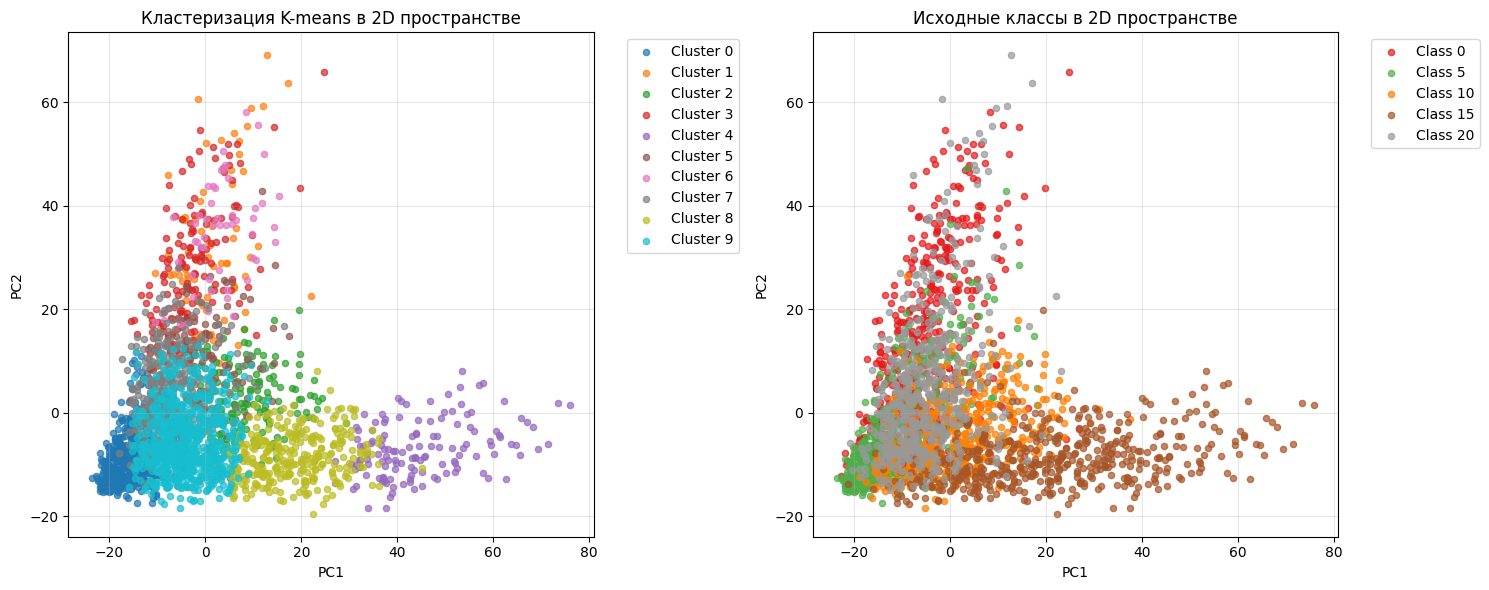

Анализ качества кластеризации:
Adjusted Rand Index: 0.236
Normalized Mutual Information: 0.379
Чем выше значения, тем лучше кластеризация соответствует исходным классам


In [9]:

# Применяем PCA для снижения размерности до 2D
pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(all_embeddings)

print(f"PCA объясняет {pca.explained_variance_ratio_.sum():.3f} дисперсии")
print(f"Компонента 1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Компонента 2: {pca.explained_variance_ratio_[1]:.3f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Визуализация по кластерам
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster in range(n_clusters):
    indices = np.where(pseudo_labels == cluster)[0]
    ax1.scatter(emb_2d[indices, 0], emb_2d[indices, 1], 
               c=[colors[cluster]], label=f'Cluster {cluster}', s=20, alpha=0.7)

ax1.set_title("Кластеризация K-means в 2D пространстве")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Визуализация по исходным классам
class_colors = plt.cm.Set1(np.linspace(0, 1, len(selected_classes)))
for i, class_id in enumerate(selected_classes):
    indices = np.where(all_labels == class_id)[0]
    ax2.scatter(emb_2d[indices, 0], emb_2d[indices, 1], 
               c=[class_colors[i]], label=f'Class {class_id}', s=20, alpha=0.7)

ax2.set_title("Исходные классы в 2D пространстве")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Анализ качества кластеризации:")
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_score = adjusted_rand_score(all_labels, pseudo_labels)
nmi_score = normalized_mutual_info_score(all_labels, pseudo_labels)

print(f"Adjusted Rand Index: {ari_score:.3f}")
print(f"Normalized Mutual Information: {nmi_score:.3f}")
print("Чем выше значения, тем лучше кластеризация соответствует исходным классам")


### Шаг 5: Стратификация по кластерам

Теперь разделим данные на train/val используя кластеры вместо исходных классов:


In [10]:
print("Стратифицируем данные по кластерам...")

sss_embedding = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx_embedding, val_idx_embedding = next(sss_embedding.split(subset_samples, pseudo_labels))

train_samples_embedding = [subset_samples[i] for i in train_idx_embedding]
val_samples_embedding = [subset_samples[i] for i in val_idx_embedding]

print(f" Стратификация по эмбедингам:")
print(f"   Train: {len(train_samples_embedding)} образцов")
print(f"   Val: {len(val_samples_embedding)} образцов")

def analyze_embedding_split(samples, name):
    labels = [label for _, label in samples]
    class_counts = Counter(labels)
    print(f"📊 {name} - распределение исходных классов:")
    for class_id in selected_classes:
        count = class_counts.get(class_id, 0)
        percentage = count / len(labels) * 100
        print(f"   Класс {class_id}: {count} образцов ({percentage:.1f}%)")

analyze_embedding_split(train_samples_embedding, "Train (по эмбедингам)")
analyze_embedding_split(val_samples_embedding, "Val (по эмбедингам)")


Стратифицируем данные по кластерам...
 Стратификация по эмбедингам:
   Train: 2000 образцов
   Val: 500 образцов
📊 Train (по эмбедингам) - распределение исходных классов:
   Класс 0: 405 образцов (20.2%)
   Класс 5: 397 образцов (19.9%)
   Класс 10: 398 образцов (19.9%)
   Класс 15: 406 образцов (20.3%)
   Класс 20: 394 образцов (19.7%)
📊 Val (по эмбедингам) - распределение исходных классов:
   Класс 0: 95 образцов (19.0%)
   Класс 5: 103 образцов (20.6%)
   Класс 10: 102 образцов (20.4%)
   Класс 15: 94 образцов (18.8%)
   Класс 20: 106 образцов (21.2%)


---

## Часть 5: DataLoader с OpenCV и Albumentations

### Зачем использовать OpenCV?
- **Быстрее** чем PIL для некоторых операций
- **Больше возможностей** для аугментаций
- **Лучшая интеграция** с библиотекой Albumentations
- **Поддержка** различных форматов изображений

####  Что такое Albumentations?
- Современная библиотека для аугментаций
- Оптимизирована для компьютерного зрения
- Поддерживает как PIL, так и OpenCV
- Простой и гибкий API

** Создадим DataLoader с OpenCV и Albumentations:**


In [11]:
class TinyImageNetAlbumentationsDataset(Dataset):
    """
    Датасет Tiny ImageNet с OpenCV + Albumentations
    
    Преимущества:
    - Быстрая загрузка через OpenCV
    - Мощные аугментации через Albumentations
    - Поддержка различных форматов
    """
    def __init__(self, root_dir, split='train', augmentation=None):
        self.root_dir = root_dir
        self.split = split
        self.augmentation = augmentation

        # Загружаем названия классов
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f.readlines()]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        
        print(f"📊 Найдено {len(self.class_names)} классов")

        # Собираем данные
        self.samples = self._make_dataset()
        print(f"📁 Загружено {len(self.samples)} образцов для {self.split}")

    def _make_dataset(self):
        """Создаем список образцов данных"""
        data = []

        if self.split == 'train':
            data = self._load_train_data()
        elif self.split == 'val':
            data = self._load_val_data()
        elif self.split == 'test':
            data = self._load_test_data()
        else:
            raise ValueError(f"Unknown split: {self.split}")

        return data

    def _load_train_data(self):
        """Загружаем тренировочные данные"""
        data = []
        train_dir = os.path.join(self.root_dir, 'train')
        for cls_name in os.listdir(train_dir):
            img_dir = os.path.join(train_dir, cls_name, 'images')
            if not os.path.isdir(img_dir):
                continue
            for img_name in os.listdir(img_dir):
                img_path = os.path.join(img_dir, img_name)
                label = self.class_to_idx[cls_name]
                data.append((img_path, label))
        return data

    def _load_val_data(self):
        """Загружаем валидационные данные"""
        data = []
        val_dir = os.path.join(self.root_dir, 'val')
        img_dir = os.path.join(val_dir, 'images')
        anno_file = os.path.join(val_dir, 'val_annotations.txt')

        label_map = {}
        with open(anno_file, 'r') as f:
            for line in f.readlines():
                img_name, cls_name, *_ = line.strip().split('\t')
                label_map[img_name] = self.class_to_idx[cls_name]

        for img_name in os.listdir(img_dir):
            if img_name in label_map:
                img_path = os.path.join(img_dir, img_name)
                label = label_map[img_name]
                data.append((img_path, label))
        return data

    def _load_test_data(self):
        """Загружаем тестовые данные"""
        data = []
        test_dir = os.path.join(self.root_dir, 'test', 'images')
        for img_name in os.listdir(test_dir):
            img_path = os.path.join(test_dir, img_name)
            data.append((img_path, -1))  # нет меток
        return data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """Возвращаем образец по индексу"""
        img_path, label = self.samples[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB


        # Применяем аугментации
        if self.augmentation:
            augmented = self.augmentation(image=img)
            img = augmented['image']

        return img, label


### Создание аугментаций с помощью Albumentations


In [ ]:
# Создаем мощные аугментации с помощью Albumentations

train_aug = A.Compose([
    # Изменение размера
    A.Resize(72, 72),
    A.RandomResizedCrop(64, 64, scale=(0.8, 1.0)),
    
    # Геометрические трансформации
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    
    # Цветовые аугментации
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    
    # Шум и размытие
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    
    # Нормализация и преобразование в тензор
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Валидационные аугментации (только базовые)
val_aug = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



train_dataset_cv = TinyImageNetAlbumentationsDataset(
    root_dir="data/tiny-imagenet-200",
    split="train",
    augmentation=train_aug
)

val_dataset_cv = TinyImageNetAlbumentationsDataset(
    root_dir="data/tiny-imagenet-200",
    split="val",
    augmentation=val_aug
)

train_loader_cv = DataLoader(train_dataset_cv, batch_size=8, shuffle=True, num_workers=2)
val_loader_cv = DataLoader(val_dataset_cv, batch_size=8, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset_cv)}")
print(f"Val size: {len(val_dataset_cv)}")

print("Тестируем OpenCV DataLoader...")
images_cv, labels_cv = next(iter(train_loader_cv))

print(f"Размер батча: {images_cv.shape}")
print(f"Тип данных: {images_cv.dtype}")
print(f"Диапазон значений: [{images_cv.min():.3f}, {images_cv.max():.3f}]")

# Визуализируем результаты
def denormalize_cv(img_tensor):
    """Денормализация для OpenCV изображений"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img_vis = denormalize_cv(images_cv[i])
    plt.imshow(img_vis)
    plt.title(f"Class: {labels_cv[i].item()}")
    plt.axis('off')
plt.suptitle("OpenCV + Albumentations DataLoader", fontsize=16)
plt.tight_layout()
plt.show()


---

### Создание кастомной ResNet модели


In [ ]:
# Заполните пропуски в BasicBlock
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        # if in_channels == out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        #

        self.downsample = nn.Identity()
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        x0 = x # то что потом будем складывать
        x0 = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))

        out = self.relu(self.bn2(self.conv2(out)))

        out += x0
        out = self.relu(out)
        
        return out



basic_block = BasicBlock(64, 128)
test_input = torch.randn(2, 64, 32, 32)

output = basic_block(test_input)
print(output.shape)

torch.Size([2, 128, 32, 32])


In [ ]:
class BottleneckBlock(nn.Module):
    """
    Bottleneck блок ResNet (1x1 -> 3x3 -> 1x1)
    Более эффективен для глубоких сетей
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки
        downsample (nn.Module): слой для изменения размерности
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
    def forward(self, x):
        
        return None


bottleneck_block = BottleneckBlock(64, 256)
test_input = torch.randn(2, 64, 32, 32)

output = bottleneck_block(test_input)


### Архитектура ResNet



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleResNet18(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        self.conv1 = nn.Conv2(3, 64, kernel_size=7, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2)

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.basic_block_4_0 = BasicBlock(256, 512)
        self.basic_block_4_1 = BasicBlock(512, 512)

    def forward(self, x):

        return x


model = SimpleResNet18(num_classes=200)
test_input = torch.randn(1, 3, 224, 224)

output = model(test_input)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")




In [ ]:
# Обучение
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одного эпоха обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    

    pbar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (data, target) in enumerate(train_loader):

        pass

    
    return 0.0, 0.0  # TODO: Замените на правильные значения


## 🔍 Задание 2: Функция валидации (Заготовка)

Напишите функцию для валидации модели:


In [ ]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch_idx, (data, target) in enumerate(val_loader):

            pass
    
    return 0.0, 0.0


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    """
    Основная функция для обучения модели
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох
    
    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f" Сохранена лучшая модель с точностью {val_acc:.2f}%")
        
    
    return history



In [ ]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


### Обучение



In [ ]:
# Для быстрого теста можно использовать только несколько классов

selected_classes = [0, 5, 10]

subset_train_samples = [s for s in train_dataset.samples if s[1] in selected_classes]
subset_val_samples = [s for s in val_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_train_samples)} train и {len(subset_val_samples)} val изображений "
      f"из {len(selected_classes)} классов")

# Перенумеровка классов
class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)


class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_subset_dataset = CustomDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = CustomDataset(subset_val_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)

In [ ]:

model = SimpleResNet18(BasicBlock, [2, 2, 2, 2], num_classes=200)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=5
)

plot_training_history(history)
